# ODE Lotka-Volterra With Bayesian Inference 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [2]:
##%load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Purpose
The purpose of this notebook is to demonstrate how to perform Bayesian inference on a system of ordinary differential equations (ODEs).

We will first present the Lotka-Volterra predator-prey ODE model and example data.  Next, we will solve the ODE using `scipy.odeint` and (non-Bayesian) least squares optimization.  Next, we perform Bayesian inference in PyMC using non-gradient-based samplers.  

### Key Conclusions
Based on the experiments in this notebook, the most simple and efficient method for performing Bayesian inference on the Lotka-Volterra equations was to specify the ODE system in Scipy, wrap the function as a Pytensor op, and use a Differential Evolution Metropolis (DEMetropolis) sampler in PyMC.  

## Background
### Motivation
Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using PyMC. The Lotka-Volterra model used in this example has often been used for benchmarking Bayesian inference methods (e.g., in this Stan [case study](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html), and in Chapter 16 of *Statistical Rethinking* {cite:p}`mcelreath2018statistical`.

### Lotka-Volterra Predator-Prey Model
The Lotka-Volterra model describes the interaction between a predator and prey species. This ODE given by:

$$
\begin{aligned}
\frac{d x}{dt} &=\alpha x -\beta xy \\ 
\frac{d y}{dt} &=-\gamma y + \delta xy
\end{aligned}
$$

The state vector $X(t)=[x(t),y(t)]$ comprises the densities of the prey and the predator species respectively.  Parameters $\boldsymbol{\theta}=[\alpha,\beta,\gamma,\delta, x(0),y(0)]$ are the unknowns that we wish to infer from experimental observations.  $x(0), y(0)$ are the initial values of the states needed to solve the ODE, and $\alpha,\beta,\gamma$, and $\delta$ are unknown model parameters which represent the following:  
* $\alpha$ is the growing rate of prey when there's no predator.
* $\beta$ is the dying rate of prey due to predation.
* $\gamma$ is the dying rate of predator when there is no prey.
* $\delta$ is the growing rate of predator in the presence of prey.    

### The Hudson's Bay Company data
The Lotka-Volterra predator prey model has been used to successfully explain the dynamics of natural populations of predators and prey, such as the lynx and snowshoe hare data of the Hudson's Bay Company. Since the dataset is small, we will hand-enter the values.

In [3]:
# fmt: off
data = pd.DataFrame(dict(
    year = np.arange(1900., 1921., 1),
    lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])))
data.head()
# fmt: on

,year,lynx,hare
0,1900.0,4.0,30.0
1,1901.0,6.1,47.2
2,1902.0,9.8,70.2
3,1903.0,35.2,77.4
4,1904.0,59.4,36.3


In [4]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Hudson's Bay Company Data"):
    ax.plot(data.year, data.lynx, color="b", lw=lw, marker="o", markersize=12, label="Lynx (Data)")
    ax.plot(data.year, data.hare, color="g", lw=lw, marker="+", markersize=14, label="Hare (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([1900, 1920])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pelts (Thousands)", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)
    return ax

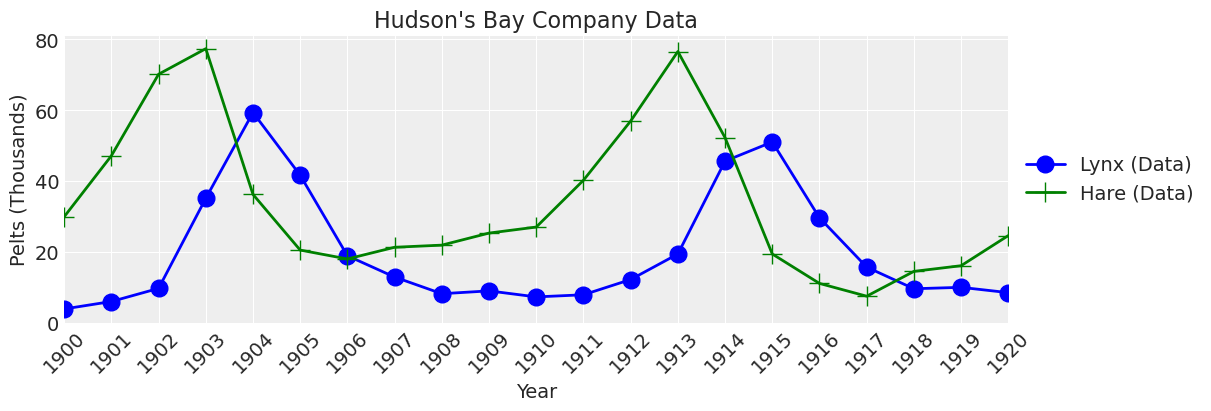

In [5]:
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax);

### Problem Statement
The purpose of this analysis is to estimate, with uncertainty, the parameters for the Lotka-Volterra model for the Hudson's Bay Company data from 1900 to 1920.  

## Scipy `odeint`

Here, we make a Python function that represents the right-hand-side of the ODE equations with the call signature needed for the `odeint` function.  Note that Scipy's `solve_ivp` could also be used, but the older `odeint` function was faster in speed tests and is therefore used in this notebook.  

In [6]:
# define the right hand side of the ODE equations in the Scipy odeint signature
from numba import njit


@njit
def rhs(X, t, theta):
    # unpack parameters
    x, y = X
    alpha, beta, gamma, delta, xt0, yt0 = theta
    # equations
    dx_dt = alpha * x - beta * x * y
    dy_dt = -gamma * y + delta * x * y
    return [dx_dt, dy_dt]

To get a feel for the model and make sure the equations are working correctly, let's run the model once with reasonable values for $\theta$ and plot the results.  

In [7]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=np.arange(1900, 1921, 0.01),
    alpha=1,
    lw=3,
    title="Hudson's Bay Company Data and\nExample Model Run",
):
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="g", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

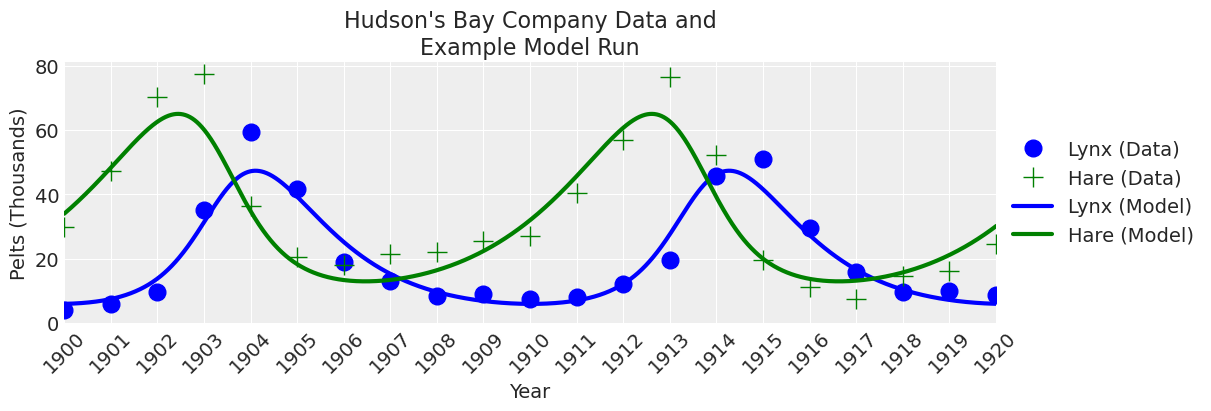

In [22]:
# note theta = alpha, beta, gamma, delta, xt0, yt0
theta = np.array([0.52, 0.026, 0.84, 0.026, 34.0, 6.0]) #5.9])
time = np.arange(1900, 1921, 0.01)

# call Scipy's odeint function
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))

# plot
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y);

Looks like the `odeint` function is working as expected.  

## Deterministic Inversion - Least Squares Solution

Suppose we have $m$ measurements $X_i= X(t_i),$ at times $t_i,$ $i=1,\ldots,m$ of the solution to a system of (differential) equations, 
$$
   f(t;\theta) = 0,
$$
where $\theta$ is an unknown, or badly known,  parameter (vector). Define the residual
$$
   r_i(\theta) = X_i - f(t_i;\theta) ,
$$
and the objective function
$$
   \Phi(\theta) = \frac{1}{2} \sum_{i=1}^{m} r_i^2 (\theta).
$$ 

Then the least-squares, deterministic inverse problem is defined as: "find the value of $\theta$ that minimizes $ \Phi(\theta).$'' 


We can solve this ODE-based parameter identification inverse problem  using scipy's `least_squares` function, which implements a Levenberg-Marquardt, modified Newton method.  

Start by creating a function that calculates the residual error.  

In [9]:
# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    return (
        data[["hare", "lynx"]] - odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))
    ).values.flatten()

Feed the residual error function to the Scipy `least_squares` solver.   

In [10]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=theta)

# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["alpha", "beta", "gamma", "delta", "h0", "l0"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(2)

,Parameter,Least Squares Solution
0,alpha,0.48
1,beta,0.02
2,gamma,0.93
3,delta,0.03
4,h0,34.91
5,l0,3.86


Plot  

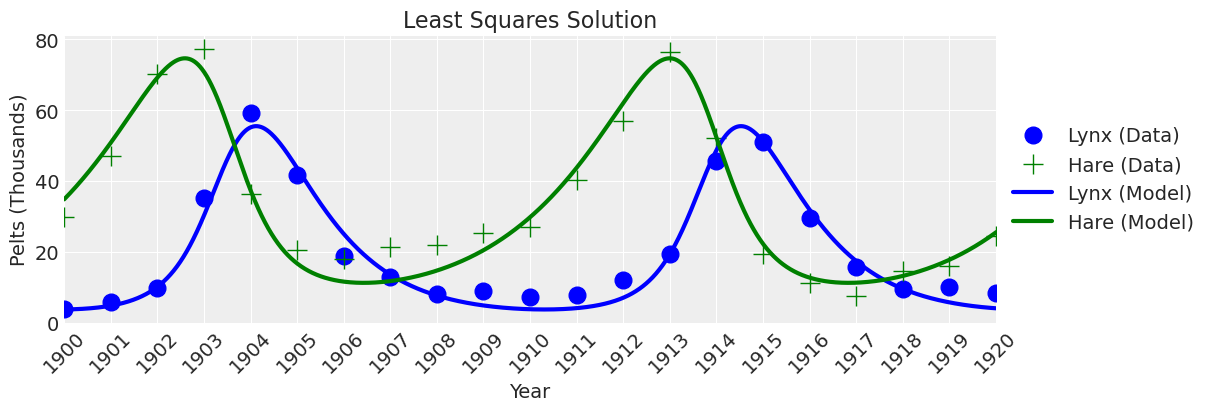

In [11]:
time = np.arange(1900, 1921, 0.01)
theta = results.x
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y, title="Least Squares Solution");

Looks right.  If we didn't care about uncertainty, then we would be done.  But we do care about uncertainty, so let's move on to Bayesian inference.  

## PyMC Model Specification for Gradient-Free Bayesian Inference

Like other Numpy or Scipy-based functions, the `scipy.integrate.odeint` function cannot be used directly in a PyMC model because PyMC needs to know the variable input and output types to compile.  Therefore, we use a Pytensor wrapper to give the variable types to PyMC.  Then the function can be used in PyMC in conjunction with gradient-free samplers.   

### Convert Python Function to a Pytensor Operator using @as_op decorator
We tell PyMC the input variable types and the output variable types using the `@as_op` decorator.  `odeint` returns Numpy arrays, but we tell PyMC that they are Pytensor double float tensors for this purpose.  

In [12]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))

### PyMC Model

Now, we can specify the PyMC model using the ode solver!  For priors, we will use the results from the least squares calculation (`results.x`) to assign priors that start in the right range.  These are empirically derived weakly informative priors.  We also make them positive-only for this problem.      

We will use a normal likelihood on untransformed data (i.e., not log transformed) to best fit the peaks of the data. 

In [13]:
theta = results.x  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([alpha, beta, gamma, delta, xt0, yt0])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

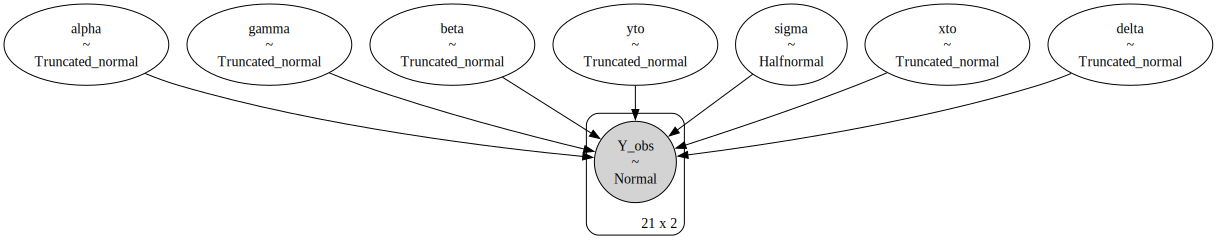

In [14]:
pm.model_to_graphviz(model=model)

### Plotting Functions
A couple of plotting functions that we will reuse below.  

In [15]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["alpha", "beta", "gamma", "delta", "xto", "yto"]
    row = trace_df.iloc[row_idx, :][cols].values

    # alpha, beta, gamma, delta, Xt0, Yt0
    time = np.arange(1900, 1921, 0.01)
    theta = row
    x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [16]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hudson's Bay Company Data and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)


## Gradient-Free Sampler Options
Having good gradient free samplers can open up the models that can be fit within PyMC.  There are five options for gradient-free samplers in PyMC that are applicable to this problem: 
* `Slice` - the default gradient-free sampler
* `DEMetropolisZ` - a differential evolution Metropolis sampler that uses the past to inform sampling jumps
* `DEMetropolis` - a differential evolution Metropolis sampler
* `Metropolis` - the vanilla Metropolis sampler
* `SMC` - Sequential Monte Carlo  

Here we only use what turns out to be the best option, `DEMetropolis`. For the full comparison, please consult the original [PYMC](https://www.pymc.io/welcome.html) version [here](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html).        

In [17]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

### DEMetropolis Sampler

In [18]:
sampler = "DEMetropolis"
chains = 8
draws = 6000
with model:
    trace_DEM = pm.sample(step=[pm.DEMetropolis(vars_list)], draws=draws, chains=chains)
trace = trace_DEM
az.summary(trace)

Population sampling (8 chains)
DEMetropolis: [alpha, beta, gamma, delta, xto, yto, sigma]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


/Users/markasch/Library/jupyterlab-desktop/envs/MAKUTU-BIP/lib/python3.13/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Population parallelization failed. Falling back to sequential stepping of chains.


Sampling 8 chains for 1_000 tune and 6_000 draw iterations (8_000 + 48_000 draws total) took 45 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.483,0.021,0.444,0.524,0.001,0.000,1333.0,3358.0,1.01
beta,0.025,0.001,0.023,0.027,0.000,0.000,1412.0,3327.0,1.01
gamma,0.924,0.045,0.837,1.006,0.001,0.001,1265.0,3562.0,1.01
delta,0.027,0.001,0.025,0.030,0.000,0.000,1578.0,3372.0,1.01
xto,34.872,0.744,33.476,36.268,0.018,0.010,1743.0,3400.0,1.00
yto,3.900,0.417,3.133,4.699,0.011,0.006,1508.0,3351.0,1.00
sigma,4.046,0.409,3.335,4.827,0.011,0.011,1430.0,1759.0,1.00


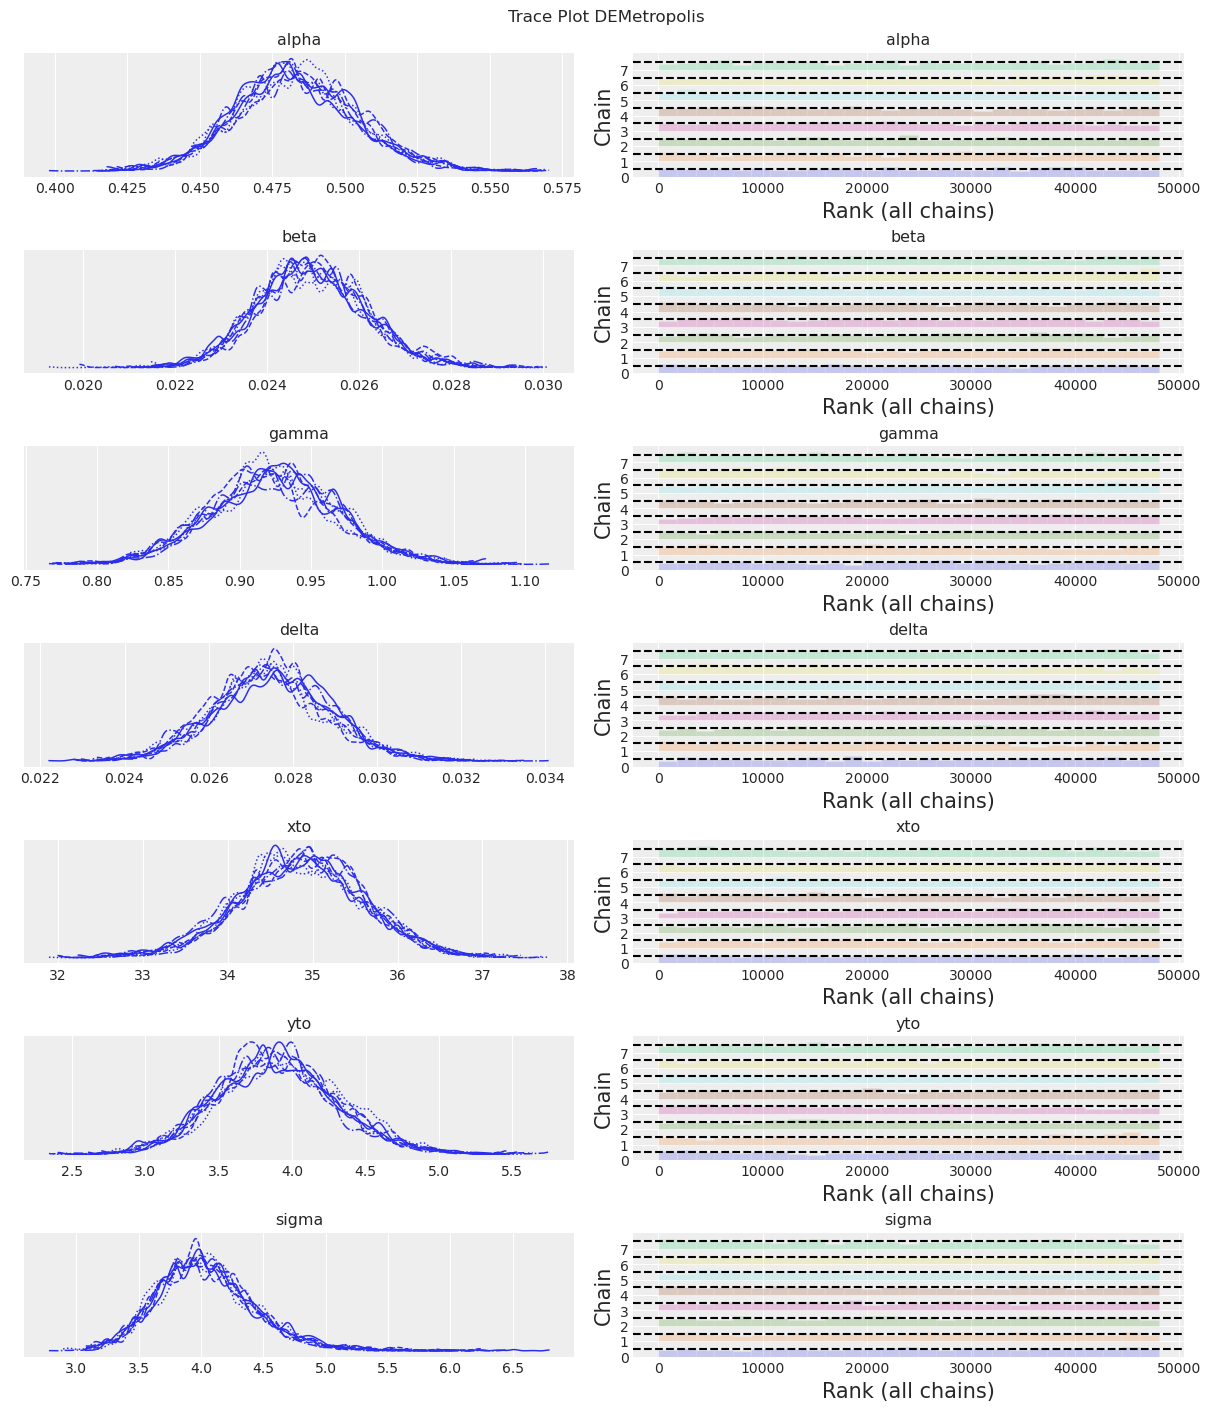

In [19]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

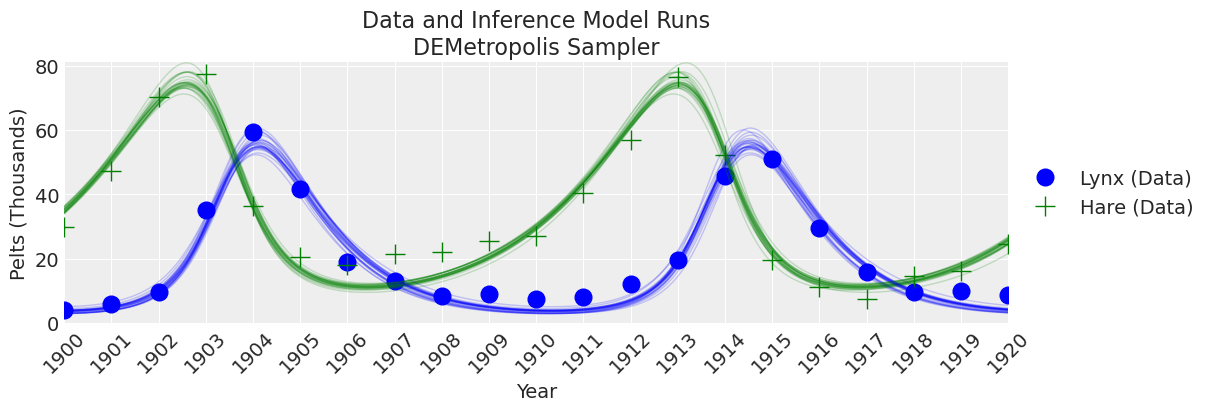

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
KDEs looks too wiggly, but ESS is high, R-hat is good, and rank_plots also look good.

### Posterior Correlations
As an aside, it is worth pointing out that the posterior parameter space is a difficult geometry for sampling.  

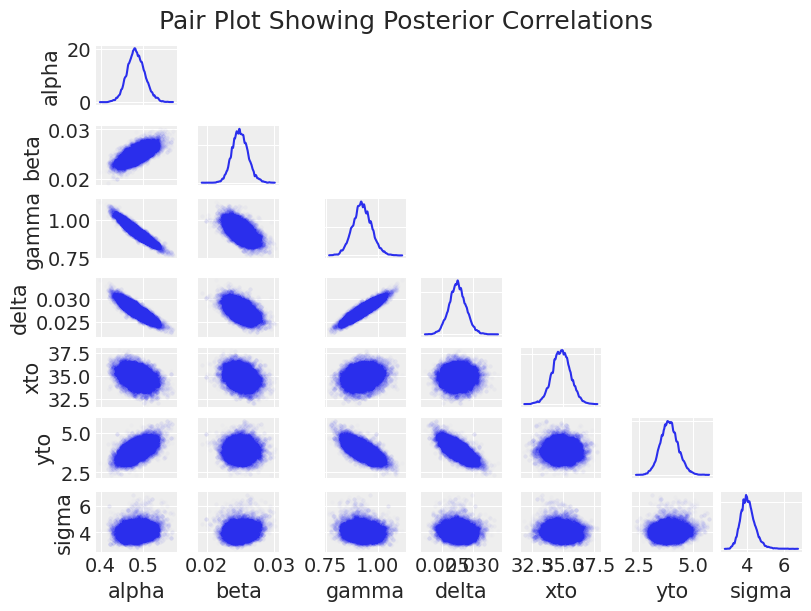

In [21]:
az.plot_pair(trace_DEM, figsize=(8, 6), scatter_kwargs=dict(alpha=0.01), marginals=True)
plt.suptitle("Pair Plot Showing Posterior Correlations", size=18);

The major observation here is that the posterior shape is pretty difficult for a sampler to handle, with positive correlations, negative correlations, crecent-shapes, and large variations in scale.  This contributes to the slow sampling (in addition to the computational overhead in solving the ODE thousands of times).  This is also fun to look at for understanding how the model parameters impact each other.       

## Bayesian Inference with Gradients

NUTS, the PyMC default sampler can only be used if gradients are supplied to the sampler.  We can solve the system of ODEs within PyMC in two different ways that supply the sampler with gradients.  The first is the built-in `pymc.ode.DifferentialEquation` solver, and the second is to forward simulate using `pytensor.scan`, which allows looping.  Note that there may be other better and faster ways to perform Bayesian inference with ODEs using gradients, such as the [sunode](https://sunode.readthedocs.io/en/latest/index.html) project, and [diffrax](https://www.pymc-labs.io/blog-posts/jax-functions-in-pymc-3-quick-examples/), which relies on JAX.

## Summary

Let's compare inference results among these different methods.  Recall that, in order to run this notebook in a reasonable amount of time, we have an insufficient number of samples for many inference methods.  For a fair comparison, we would need to bump up the number of samples and run the notebook for longer.  Regardless, let's take a look.     

### Key Conclusions
We performed Bayesian inference on a system of ODEs in 4 main ways: 
* Scipy `odeint` wrapped in a Pytensor `op` and sampled with non-gradient-based samplers (comparing 5 different samplers).  
* Scipy `odeint` wrapped in a `pm.Simulator` function and sampled with a non-likelihood-based sequential Monte Carlo (SMC) sampler.  
* PyMC `ode.DifferentialEquation` sampled with NUTs.  
* Forward simulation using `pytensor.scan` and sampled with NUTs.  

The "winner" for this problem was the Scipy `odeint` solver with a differential evolution (DE) Metropolis sampler and SMC (for a model with a Likelihood) provide good results with SMC being somewhat slower (but also better diagnostics). The improved efficiency of the NUTS sampler did not make up for the inefficiency in using the slow ODE solvers with gradients.  Both DEMetropolis and SMC enable the simplest workflow for a scientist with a working numeric model and the desire to perform Bayesian inference. Just wrapping the numeric model in a Pytensor op and plugging it into a PyMC model can get you a long way!

## Authors
Organized and rewritten by [Greg Brunkhorst](https://github.com/gbrunkhorst)  from multiple legacy PyMC.io example notebooks by Sanmitra Ghosh, Demetri Pananos, and the PyMC Team ({ref}`ABC_introduction`).

Osvaldo Martin added some clarification about SMC-ABC and  minor fixes in Mar, 2023